In [7]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/datas.zip'
extract_path = '/content/dataset/'

# Extract dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
import os


train_data_dir='/content/dataset/train/'
validation_data_dir='/content/dataset/test/'


train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(48, 48),
					batch_size=32,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(48, 48),
							batch_size=32,
							class_mode='categorical',
							shuffle=True)


class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

img, label = train_generator.__next__()


model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


train_path = "/content/dataset/train/"
test_path = "/content/dataset/test/"

num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)

num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)
epochs=30

history=model.fit(train_generator,
                steps_per_epoch=num_train_imgs//32,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=num_test_imgs//32)

model.save('model_file.h5')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPooli  (None,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


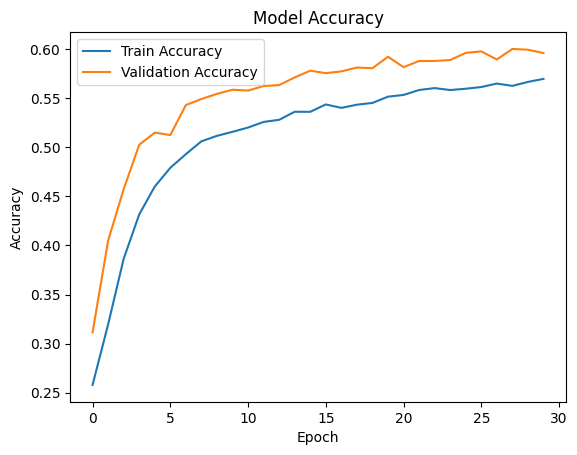

224/224 [==============================] - 31s 140ms/step - loss: 1.0751 - accuracy: 0.5961
Test Loss: 1.075100302696228
Test Accuracy: 0.5961216688156128


In [13]:
import matplotlib.pyplot as plt
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(validation_generator, steps=num_test_imgs//32)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

model=load_model('model_file.h5')

video=cv2.VideoCapture(0)

faceDetect=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

labels_dict={0:'Angry',1:'Disgust', 2:'Fear', 3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

while True:
    ret,frame=video.read()
    gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces= faceDetect.detectMultiScale(gray, 1.3, 3)
    for x,y,w,h in faces:
        sub_face_img=gray[y:y+h, x:x+w]
        resized=cv2.resize(sub_face_img,(48,48))
        normalize=resized/255.0
        reshaped=np.reshape(normalize, (1, 48, 48, 1))
        result=model.predict(reshaped)
        label=np.argmax(result, axis=1)[0]
        print(label)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 1)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(50,50,255),2)
        cv2.rectangle(frame,(x,y-40),(x+w,y),(50,50,255),-1)
        cv2.putText(frame, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow("Frame",frame)
    k=cv2.waitKey(1)
    if k==ord('q'):
        break

video.release()
cv2.destroyAllWindows()